In [25]:
# standard packages
import re
import pandas as pd
import numpy as np
import scipy as sp
import plotnine

# mechciene learning tools
import sklearn as skl
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sklearn.preprocessing
import sklearn.mixture
import matplotlib.pyplot as plt
from hmmlearn import hmm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [119]:
# import data
scifi = pd.read_csv("audible_scifi.csv")

# list of dtypes to include 
include =['object', 'float', 'int'] 
  

In [120]:
# calling describe method 
scifi.describe(include = include)
#scifi.info()

,author,categories,narrator,number_of_ratings,runtime,series,stars,summary,title,total_mins,url,year
count,1147,1150,1143,1129.000000,1147,976,1129.000000,1135,1150,1112.000000,1150,1096.000000
unique,445,47,403,NaN,762,917,NaN,1097,1093,NaN,1112,NaN
top,Jim Butcher,Contemporary,Nick Podehl,NaN,10 hrs and 12 mins,The Witcher Saga,NaN,Publisher's Summary Three tim...,Super Sales on Super Heroes,NaN,https://www.audible.com/pd/Stone-of-Tears-Audi...,NaN
freq,26,351,39,NaN,6,5,NaN,2,3,NaN,2,NaN
mean,NaN,NaN,NaN,7255.053144,NaN,NaN,4.562710,NaN,NaN,921.312050,NaN,2011.670620
std,NaN,NaN,NaN,12498.981276,NaN,NaN,0.229477,NaN,NaN,598.037294,NaN,11.335083
min,NaN,NaN,NaN,2.000000,NaN,NaN,3.300000,NaN,NaN,77.000000,NaN,1932.000000
25%,NaN,NaN,NaN,893.000000,NaN,NaN,4.400000,NaN,NaN,591.000000,NaN,2010.000000
50%,NaN,NaN,NaN,3434.000000,NaN,NaN,4.600000,NaN,NaN,746.500000,NaN,2016.000000
75%,NaN,NaN,NaN,8539.000000,NaN,NaN,4.700000,NaN,NaN,1070.500000,NaN,2019.000000


In [162]:
# clean up dataset
# clean categories, with only the first listed sub-genre
scifi['prime_category'] = [cat.replace(' ', '').split(',')[0].rstrip('s') for cat in scifi.categories]

#trim off Arts and Bios becuase they don't have enough data to make meaningful conclusions
scifi['prime_category'].value_counts()
scifi.loc[scifi.prime_category == "Bios&Memoir", 'prime_category'] = np.nan
scifi.loc[scifi.prime_category == "Arts&Entertainment", 'prime_category'] = np.nan

In [163]:
# series indicator variable
scifi['is_series'] = [1 if type(elt) == str else 0 for elt in scifi.series]
scifi.groupby(by = 'prime_category')['year'].mean()

prime_category
Classic               1974.031250
Contemporary          2012.541538
Epic                  2011.083612
Fiction               2011.914634
Mysteries&Thriller    2014.482143
Paranormal            2012.200000
Romance               2014.400000
Sci-Fi&Fantasy        2015.740741
Name: year, dtype: float64

In [122]:
no_mins = pd.DataFrame(scifi.runtime[np.isnan(scifi.total_mins)])
split_time = [elt.split(' ') if type(elt) == str else "none" for elt in no_mins.runtime]
correct_mins = [np.int(elt[0])*60 if elt[1] == 'hrs' else (np.int(elt[0]) if elt[1] == 'mins' else np.nan) for elt in split_time]

In [123]:
for i, mins in zip(no_mins.index, correct_mins):
    scifi.loc[i ,'total_mins'] = mins

C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:449: UserWarning: geom_point : Removed 21 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


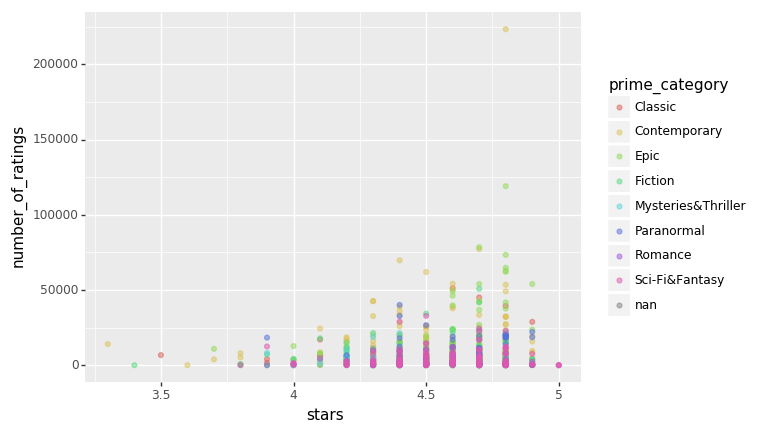

<ggplot: (-9223371902780396884)>

In [172]:
(plotnine.ggplot(scifi, plotnine.aes( y = "number_of_ratings", x = "stars", color = "prime_category")) +
plotnine.geom_point(alpha = .5))

C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:360: UserWarning: stat_boxplot : Removed 4 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


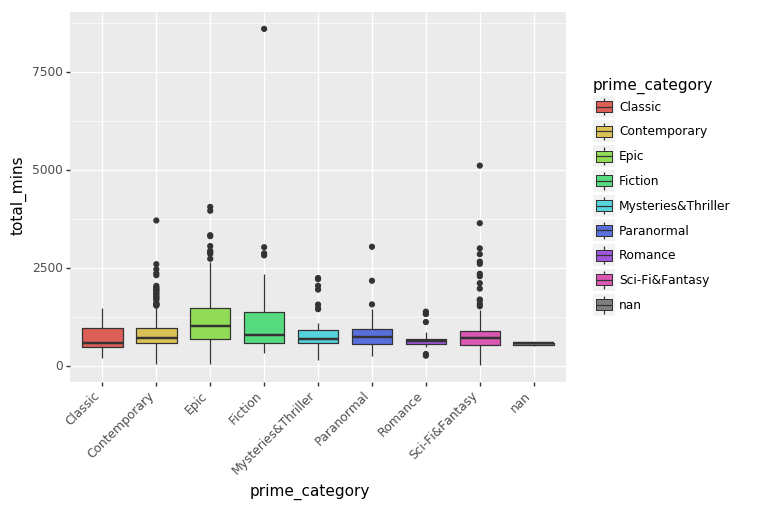

<ggplot: (134074339248)>

In [167]:
# some intial exploration and visualization
(plotnine.ggplot(scifi, plotnine.aes( y = 'total_mins', x = 'prime_category', fill = 'prime_category')) + 
 plotnine.geom_boxplot() +
 plotnine.theme(axis_text_x = plotnine.element_text(rotation=45, hjust=1)))

C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:360: UserWarning: stat_boxplot : Removed 54 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


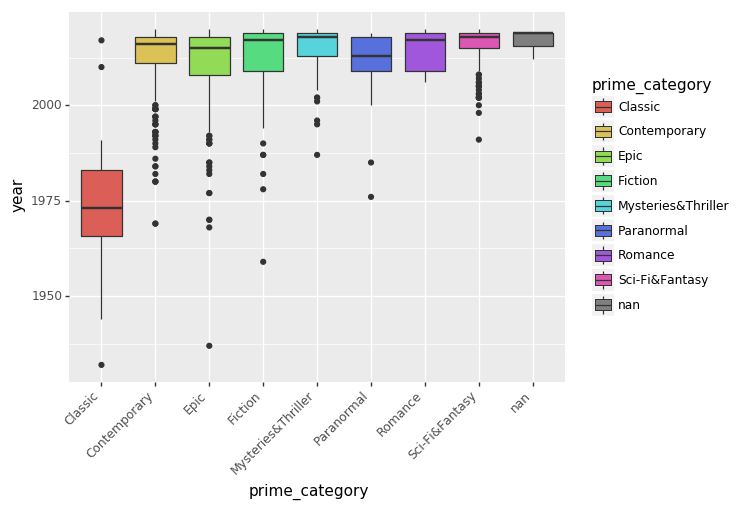

<ggplot: (-9223371902780396842)>

In [168]:
(plotnine.ggplot(scifi, plotnine.aes( y = 'year', x = 'prime_category', fill = 'prime_category')) + 
 plotnine.geom_boxplot() +
 plotnine.theme(axis_text_x = plotnine.element_text(rotation=45, hjust=1)))

C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:360: UserWarning: stat_boxplot : Removed 4 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


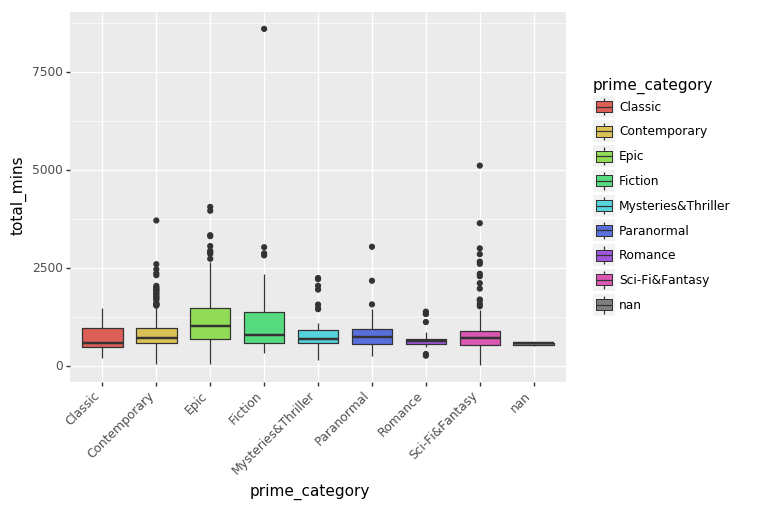

<ggplot: (134074783282)>

In [169]:
(plotnine.ggplot(scifi, plotnine.aes( y = 'total_mins', x = 'prime_category', fill = 'prime_category')) + 
 plotnine.geom_boxplot() +
 plotnine.theme(axis_text_x = plotnine.element_text(rotation=45, hjust=1)))

C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:360: UserWarning: stat_boxplot : Removed 21 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


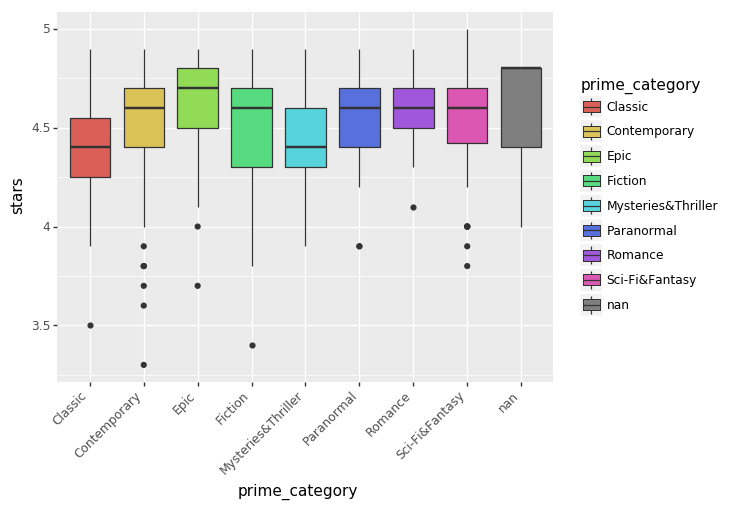

<ggplot: (134074943436)>

In [170]:
(plotnine.ggplot(scifi, plotnine.aes( y = 'stars', x = 'prime_category', fill = 'prime_category')) + 
 plotnine.geom_boxplot() +
 plotnine.theme(axis_text_x = plotnine.element_text(rotation=45, hjust=1)))

C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\layer.py:360: UserWarning: stat_boxplot : Removed 21 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\cmfmiller\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\stats\stat.py:310: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  stats = pd.concat(stats, axis=0, ignore_index=True)


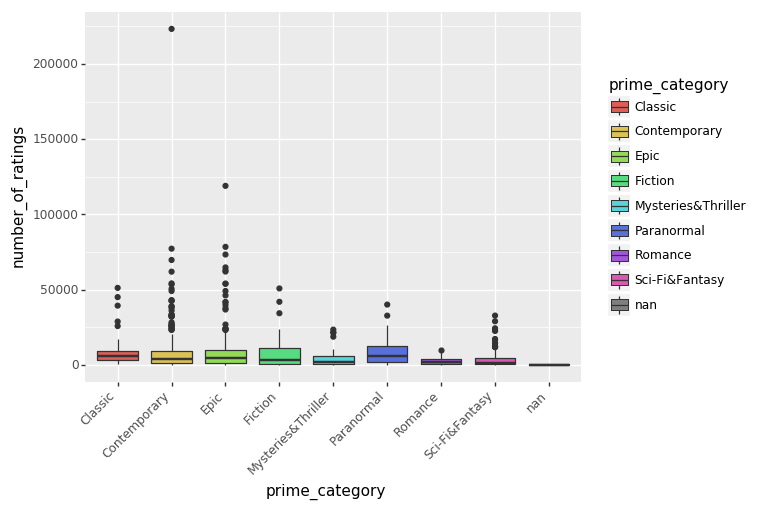

<ggplot: (134075134300)>

In [171]:
(plotnine.ggplot(scifi, plotnine.aes( y = 'number_of_ratings', x = 'prime_category', fill = 'prime_category')) + 
 plotnine.geom_boxplot() +
 plotnine.theme(axis_text_x = plotnine.element_text(rotation=45, hjust=1)))